# RSI

This script is using the yfinance library to download historical stock data for a given ticker symbol, and then using that data to create a machine learning model using the HistGradientBoostingRegressor class from scikit-learn. The script then use the model to make predictions for the next 30 days, and plots the predictions with the historical data. Additionally, it calculates the relative strength index (RSI) for the last year and the next 30 days and add some random noise to the predictions to make them more realistic. Finally, it concatenates the historical data and the predictions and then saves the result in predictions_df variable.

Enter the stock ticker symbol or 'exit' to finish: AAPL


[*********************100%%**********************]  1 of 1 completed


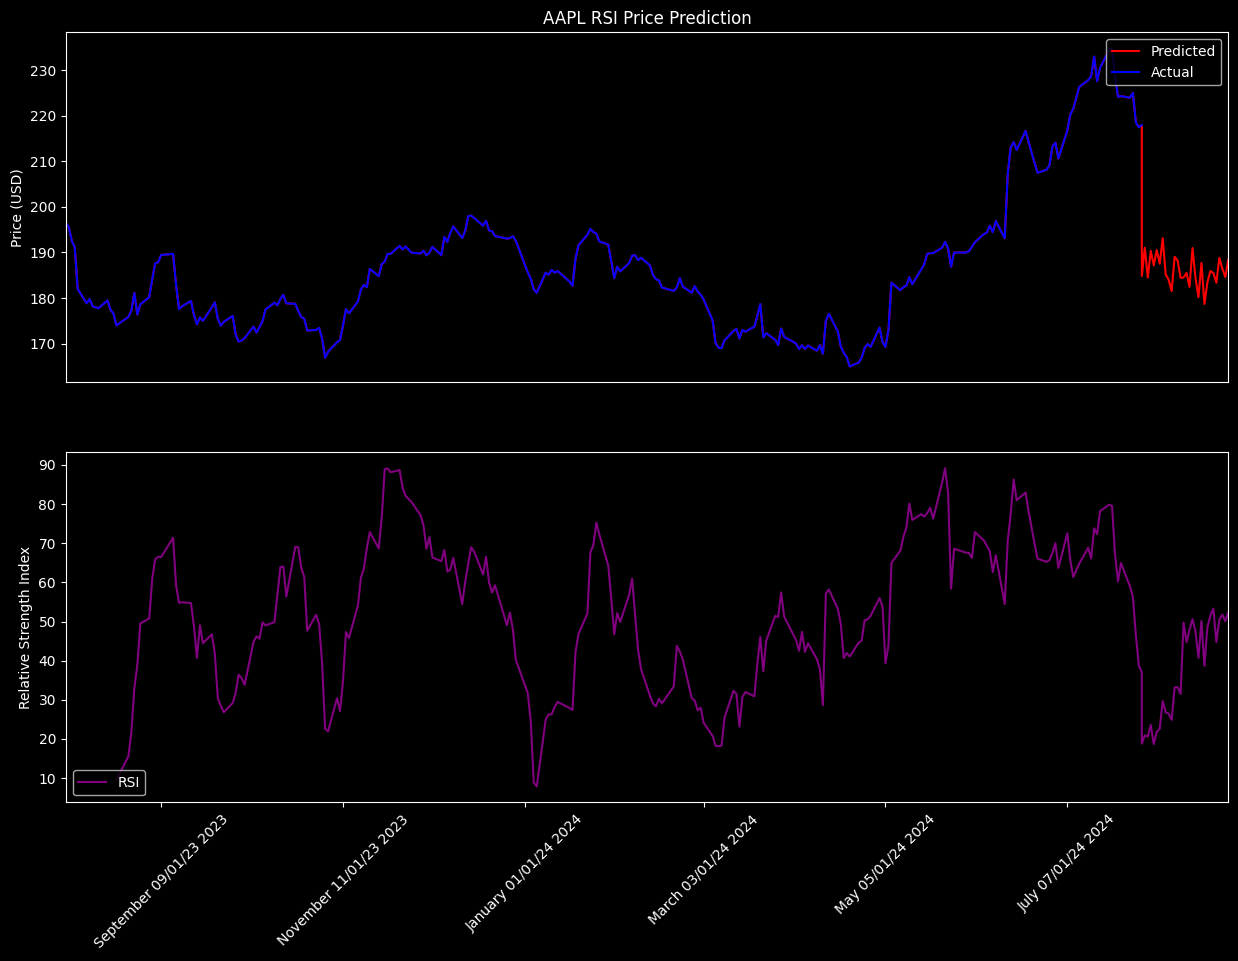

KeyboardInterrupt: Interrupted by user

In [ ]:
import os
import warnings
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from sklearn.ensemble import HistGradientBoostingRegressor

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated.*")

while True:
    # Ask the user for the stock ticker symbol
    stock_ticker = input("Enter the stock ticker symbol or 'exit' to finish: ")
    if stock_ticker.lower() == 'exit':
        break

    # Get today's date
    today = datetime.datetime.now().date()

    # Subtract 365 days from today's date
    one_year_ago = today - datetime.timedelta(days=365)

    # Use the date one year ago as the start parameter in yf.download()
    data = yf.download(stock_ticker, start=one_year_ago)

    if data.empty:
        print("No data available for the stock ticker symbol:", stock_ticker, ". Please try another symbol.")
        continue
    else:
        # Convert the date column to a datetime object
        data['Date'] = pd.to_datetime(data.index)

        # Set the date column as the index
        data.set_index('Date', inplace=True)

        # Sort the data by date
        data.sort_index(inplace=True)

        # Get the data for the last year
        last_year = data.iloc[-365:].copy()

        # Calculate the moving average
        last_year.loc[:,'MA'] = last_year['Close'].rolling(window=20).mean()

        # Calculate the relative strength index
        last_year['delta'] = last_year['Close'] - last_year['Close'].shift(1)
        last_year['gain'] = np.where(last_year['delta'] > 0, last_year['delta'], 0)
        last_year['loss'] = np.where(last_year['delta'] < 0, abs(last_year['delta']), 0)
        avg_gain = last_year['gain'].rolling(window=14).mean()
        avg_loss = last_year['loss'].rolling(window=14).mean()
        last_year['RS'] = avg_gain / avg_loss
        last_year['RSI'] = 100 - (100 / (1 + last_year['RS']))

        # Split the data into X (features) and y (target)
        X = last_year[['RSI']]
        y = last_year['Close']

        # Create an HistGradientBoostingRegressor instance
        model = HistGradientBoostingRegressor()

        # Fit the model with the data
        model.fit(X, y)

        # Make predictions for the next 30 days
        future_dates = pd.date_range(start=data.index[-1], periods=30, freq='D')
        future_data = pd.DataFrame(index=future_dates, columns=['RSI'])
        future_data['RSI'] = last_year['RSI'].iloc[-1]

        predictions = model.predict(future_data)
        predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

        # Calculate the standard deviation of the last year's close prices
        std_dev = last_year['Close'].std()

        # Generate random values with a standard deviation of 0.5 * the last year's close prices standard deviation
        random_values = np.random.normal(0, 0.2 * std_dev, predictions.shape)

        # Add the random values to the predicted prices
        predictions += random_values
        predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

        # Concatenate the last_year and predictions dataframes
        predictions_df = pd.concat([last_year, predictions_df])

        # Recalculate RSI for the next 30 days
        predictions_df['delta'] = predictions_df['Close'] - predictions_df['Close'].shift(1)
        predictions_df['gain'] = np.where(predictions_df['delta'] > 0, predictions_df['delta'], 0)
        predictions_df['loss'] = np.where(predictions_df['delta'] < 0, abs(predictions_df['delta']), 0)
        avg_gain = predictions_df['gain'].rolling(window=14).mean()
        avg_loss = predictions_df['loss'].rolling(window=14).mean()
        predictions_df['RS'] = avg_gain / avg_loss
        predictions_df['RSI'] = 100 - (100 / (1 + predictions_df['RS']))

        # Set the style to dark theme
        style.use('dark_background')

        # Create the plot
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))  # Adjust figsize as needed

        # Plot the predicted close prices for the next 30 days
        ax1.plot(predictions_df.index, predictions_df['Close'], color='green' if predictions_df['Close'][-1] >= last_year['Close'][-1] else 'red', label='Predicted')
        ax1.plot(last_year.index, last_year['Close'], color='blue', label='Actual')
        ax1.set_ylabel('Price (USD)')
        ax1.set_title(stock_ticker.upper() + ' RSI Price Prediction')
        ax1.set_xticks([])
        ax1.legend(loc='upper right')

        # Plot the RSI on the second chart
        ax2.plot(predictions_df.index, predictions_df['RSI'], color='purple', label='RSI')
        ax2.set_ylabel('Relative Strength Index')
        ax2.legend(loc='lower left')

        # Set x-axis as date format
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %D %Y"))
        plt.xticks(rotation=45)

        # Set the x-axis limits to be the same for both subplots
        ax1.set_xlim(predictions_df.index[0], predictions_df.index[-1])
        ax2.set_xlim(predictions_df.index[0], predictions_df.index[-1])

        # Show the plot
        plt.show()


Enter the stock ticker symbol or 'exit' to finish: GOOG


[*********************100%%**********************]  1 of 1 completed


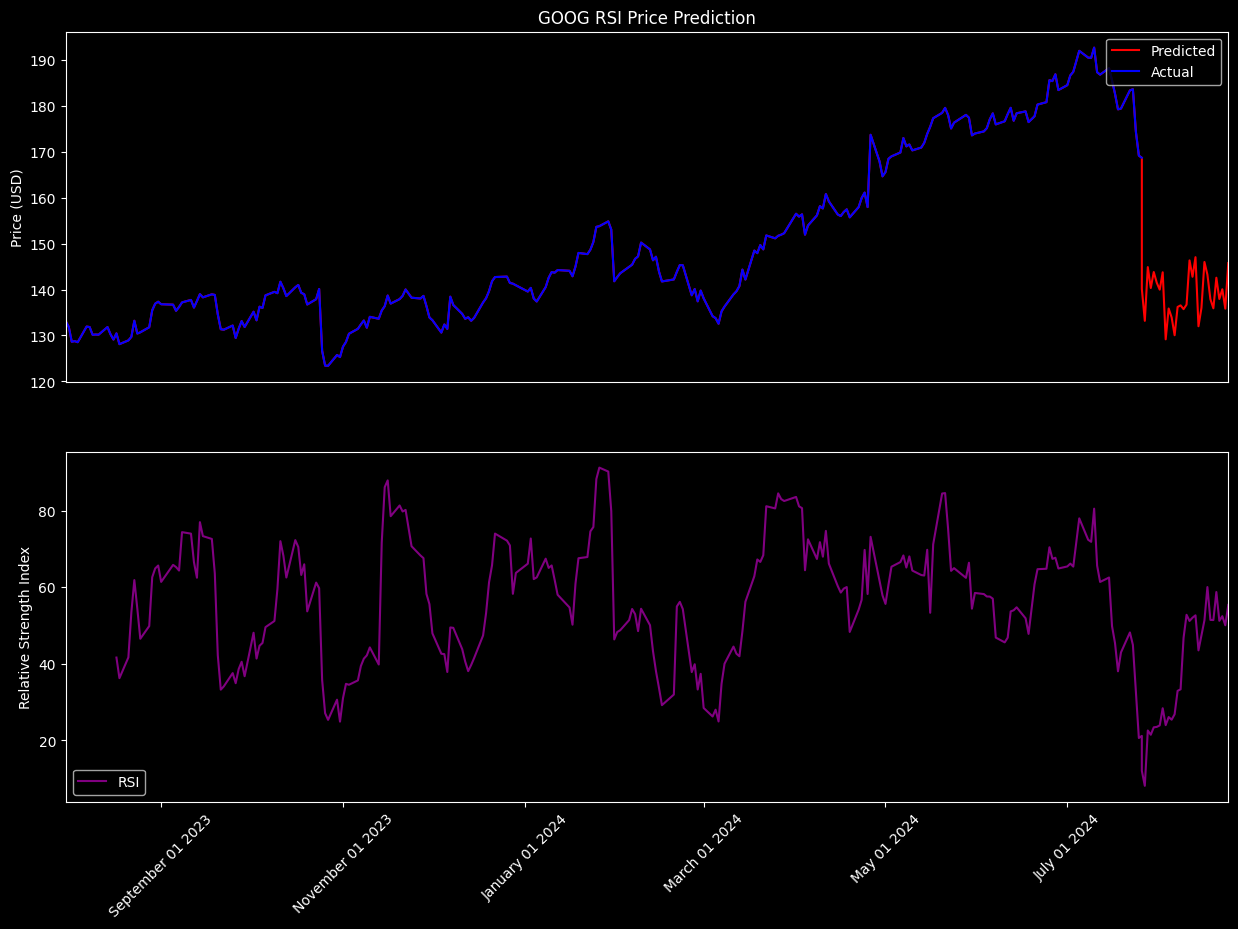

KeyboardInterrupt: Interrupted by user

In [ ]:
import os
import warnings
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from sklearn.ensemble import HistGradientBoostingRegressor

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated.*")

def fetch_stock_data(stock_ticker):
    # Get today's date
    today = datetime.datetime.now().date()

    # Subtract 365 days from today's date
    one_year_ago = today - datetime.timedelta(days=365)

    # Use the date one year ago as the start parameter in yf.download()
    data = yf.download(stock_ticker, start=one_year_ago)

    return data

def calculate_rsi_and_predict(data, stock_ticker):
    if data.empty:
        print("No data available for the stock ticker symbol:", stock_ticker, ". Please try another symbol.")
        return

    # Convert the date column to a datetime object
    data['Date'] = pd.to_datetime(data.index)

    # Set the date column as the index
    data.set_index('Date', inplace=True)

    # Sort the data by date
    data.sort_index(inplace=True)

    # Get the data for the last year
    last_year = data.iloc[-365:].copy()

    # Calculate the moving average
    last_year['MA'] = last_year['Close'].rolling(window=20).mean()

    # Calculate the relative strength index
    last_year['delta'] = last_year['Close'] - last_year['Close'].shift(1)
    last_year['gain'] = np.where(last_year['delta'] > 0, last_year['delta'], 0)
    last_year['loss'] = np.where(last_year['delta'] < 0, abs(last_year['delta']), 0)
    avg_gain = last_year['gain'].rolling(window=14).mean()
    avg_loss = last_year['loss'].rolling(window=14).mean()
    last_year['RS'] = avg_gain / avg_loss
    last_year['RSI'] = 100 - (100 / (1 + last_year['RS']))

    # Split the data into X (features) and y (target)
    X = last_year[['RSI']]
    y = last_year['Close']

    # Create a HistGradientBoostingRegressor instance
    model = HistGradientBoostingRegressor()

    # Fit the model with the data
    model.fit(X, y)

    # Make predictions for the next 30 days
    future_dates = pd.date_range(start=data.index[-1], periods=30, freq='D')
    future_data = pd.DataFrame(index=future_dates, columns=['RSI'])
    future_data['RSI'] = last_year['RSI'].iloc[-1]

    predictions = model.predict(future_data)
    predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

    # Calculate the standard deviation of the last year's close prices
    std_dev = last_year['Close'].std()

    # Generate random values with a standard deviation of 0.2 * the last year's close prices standard deviation
    random_values = np.random.normal(0, 0.2 * std_dev, predictions.shape)

    # Add the random values to the predicted prices
    predictions += random_values
    predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

    # Concatenate the last_year and predictions dataframes
    predictions_df = pd.concat([last_year, predictions_df])

    # Recalculate RSI for the next 30 days
    predictions_df['delta'] = predictions_df['Close'] - predictions_df['Close'].shift(1)
    predictions_df['gain'] = np.where(predictions_df['delta'] > 0, predictions_df['delta'], 0)
    predictions_df['loss'] = np.where(predictions_df['delta'] < 0, abs(predictions_df['delta']), 0)
    avg_gain = predictions_df['gain'].rolling(window=14).mean()
    avg_loss = predictions_df['loss'].rolling(window=14).mean()
    predictions_df['RS'] = avg_gain / avg_loss
    predictions_df['RSI'] = 100 - (100 / (1 + predictions_df['RS']))

    # Set the style to dark theme
    style.use('dark_background')

    # Create the plot with a larger figure size
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))  # Adjust figsize as needed

    # Plot the predicted close prices for the next 30 days
    ax1.plot(predictions_df.index, predictions_df['Close'], color='green' if predictions_df['Close'][-1] >= last_year['Close'][-1] else 'red', label='Predicted')
    ax1.plot(last_year.index, last_year['Close'], color='blue', label='Actual')
    ax1.set_ylabel('Price (USD)')
    ax1.set_title(stock_ticker.upper() + ' RSI Price Prediction')
    ax1.set_xticks([])
    ax1.legend(loc='upper right')

    # Plot the RSI on the second chart
    ax2.plot(predictions_df.index, predictions_df['RSI'], color='purple', label='RSI')
    ax2.set_ylabel('Relative Strength Index')
    ax2.legend(loc='lower left')

    # Set x-axis as date format
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %d %Y"))
    plt.xticks(rotation=45)

    # Set the x-axis limits to be the same for both subplots
    ax1.set_xlim(predictions_df.index[0], predictions_df.index[-1])
    ax2.set_xlim(predictions_df.index[0], predictions_df.index[-1])

    # Show the plot
    plt.show()

def main():
    while True:
        # Ask the user for the stock ticker symbol
        stock_ticker = input("Enter the stock ticker symbol or 'exit' to finish: ")
        if stock_ticker.lower() == 'exit':
            break

        # Fetch the stock data
        data = fetch_stock_data(stock_ticker)

        # Calculate RSI and predict
        calculate_rsi_and_predict(data, stock_ticker)

if __name__ == "__main__":
    main()
